# 1. Background:

Convolutional Neural Networks (CNNs) are fundamental to brain imaging. They function by applying a series of convolutional operations to an image.

CNNs apply this filtering operation repeatedly in varying sizes and formats, allowing the model to gain an *understanding* of the image. However, the complexity of the model increases substantially with the addition of more filters, leading to intensive memory and computational demands due to the vast complexity and numerous parameters [1].

A layer known as Max Pooling is incorporated into these networks. This layer maintains the same depth of the model while reducing its spatial size, thereby enhancing computational efficiency. It also preserves the key features of an image [2]. Several other layers are similarly employed to manage computation by adjusting either the depth or spatial size of the model.

It was however observed that some uncertainty propagates through the network using these techniques. For instance, assume the following 4x4 matrix:

$$
\begin{bmatrix}
7 & 7 \\
4 & 5
\end{bmatrix}
$$

A max pooling layer needs to choose which of the 7s to keep, and later, during upsampling, remember the index where the 7 was found. Different implementations or software stacks can cause different issues and contribute to numerical unstability.

# 2. Introduction

Observations from Dr. Glatard's lab suggest that replacing such occurrences with NaN values could potentially improve computational speed during both training and inference, while preserving the accuracy of the model. The logic is that parts of images with redundant information (e.g., the background) could be disregarded during the convolutional operation, as image patches containing a high count of NaN values might be ignored. Likewise, this will solve the problem mentioned above. This is hypothesized to accelerate the calculations in convolutional operations.

A Python implementation of this NaN pooling has already been developed with success in the lab, which showed promising results. However, to fully harness the potential of this approach, it must be adapted to PyTorch's C/C++ framework.

Hence, the following project is proposed: Can a C/C++ PyTorch implementation of this solution improve the speed of inference and training of CNN models and prevent uncertainty propagation while conserving current accuracy benchmarks?


# 3 Approach 1: Re-writing the current NaN python implementation using Torch's C++ extension framework

Torch offers an elegant [solution](https://pytorch.org/tutorials/advanced/cpp_extension.html) to writing your own custom C++ extensions. In essence, including the following header ```#include <torch/extension.h>``` in your C++ code, and creating a python setup.py file allows you to use Torch's existing C++ frontend, as well as extending it. 

To do so, we first created the following build files:

---
Dockerfile:
```Dockerfile
Use the latest PyTorch base image with CUDA 12.1 and cuDNN 8
FROM pytorch/pytorch:2.2.1-cuda12.1-cudnn8-devel

# Install necessary dependencies
RUN apt-get update && apt-get install -y \
    build-essential \
    cmake \
    git \
    python3-dev \
    python3-pip \
    libpython3-dev \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements.txt and install Python dependencies
COPY requirements.txt /workspace/requirements.txt
WORKDIR /workspace

# Install Python dependencies
RUN pip install --upgrade pip && \
    pip install -r requirements.txt --no-cache-dir

# Copy files into workspace
COPY . /workspace

# Set the working directory
WORKDIR /workspace
```

---
docker-compose.yml
```yaml
services:
  pytorch_cpp_extension:
    image: pytorch_cpp_extension
    build:
      context: .
    volumes:
      - .:/workspace
    working_dir: /workspace
    entrypoint: /bin/bash -c "python setup.py build_ext --inplace && python setup.py install && /bin/bash"
```

--- 
setup.py 
```python
from setuptools import setup, Extension
from torch.utils import cpp_extension

setup(
    name='nan_cpp',
    ext_modules=[cpp_extension.CppExtension('nan_cpp', ['nan.cpp'], extra_compile_args=["-g"])],
    cmdclass={'build_ext': cpp_extension.BuildExtension}
)
```

---
Combined together, these three files allow the user to create the necessary environment to build their own extensions. Furthermore, the .yml file allows for automatic mounting. By calling 

```docker-compose run --rm pytorch_cpp_extension```

A docker image will be built and and the user will be automatically attached. This will also call the necessary commands to build, compile and link the C++ and python files.




Let's take a first stab at implementing python NaN Pooling based on the following code (code can be found in the file nan_ops.py): 

```python
class NaNPool2d:

    def __init__(self, max_threshold: float = 1):
        """
        Initializes the NaNPool2d object.

        Args:
            max_threshold (float, optional): Max threshold value for determining multiple max value occurrence ratio. Defaults to 0.5.
        """
        self.max_threshold = max_threshold


    def check_for_nans(self, c, i, j, window, maxval, max_index):

        # Converting 1d indices from pool window to 2d indices
        max_index = torch.stack((max_index // self.pool_height, max_index % self.pool_width), dim=1)

        if torch.isnan(maxval).any():
            window = window.masked_fill(torch.isnan(window), float("-inf"))
            maxval = torch.max(window.reshape(self.batch_size, -1), dim=1)[0] 

        # Strict approach to identifying multiple max values
        # check_multi_max = torch.sum(window == maxval[:, None, None], axis=(1, 2))
        # Less restrictive more theoretically stable approach
        check_multi_max = torch.sum(
            torch.isclose(window, maxval[:, None, None], rtol=1e-7, equal_nan=True), axis=(1, 2)
        )
       
        # Reduce multiple max value counts to ratios in order to use passed max threshold value
        # check_multi_max = check_multi_max / (window.shape[-1] * window.shape[-2])

        if (check_multi_max > self.max_threshold).any():
            maxval = torch.where(check_multi_max > self.max_threshold, np.nan, maxval)

        # Find new index of max value if it has changed and is not NaN
        if torch.where(window == maxval)[0].numel() != 0: 
            max_index = torch.max(window.masked_fill(torch.isnan(window), float('-inf')).reshape(self.batch_size, -1), dim=1)[1]
            max_index = torch.stack((max_index // self.pool_height, max_index % self.pool_width), dim=1)

        # Calculate the indices for 1D representation
        max_index_1d = (i * self.stride_height + (max_index[:, 0])) * self.input_width + (
            j * self.stride_width + (max_index[:, 1])
        )


        self.output_array[:, c, i, j] = maxval
        self.index_array[:, c, i, j] = max_index_1d


    def __call__(self, input_array: torch.Tensor, pool_size: Tuple, strides: Tuple = None) -> Tuple:
        """
        Perform NaN-aware max pooling on the input array.

        Args:
            input_array (torch.Tensor): Input tensor of shape (batch_size, channels, input_height, input_width).
            pool_size (tuple): Size of the pooling window (pool_height, pool_width).
            strides (tuple, optional): Strides for pooling (stride_height, stride_width). Defaults to None.

        Returns:
            tuple: A tuple containing output array and index array after pooling.
        """

        batch_size, channels, input_height, input_width = input_array.shape
        # Force values to int
        self.batch_size = int(batch_size)
        channels = int(channels)
        self.input_height = int(input_height)
        self.input_width = int(input_width)

        pool_height, pool_width = pool_size
        # Force values to int
        self.pool_height = int(pool_height)
        self.pool_width = int(pool_width)

        if strides:
            stride_height, stride_width = strides

        else:
            stride_height, stride_width = pool_size

        # Force values to int
        self.stride_height = int(stride_height)
        self.stride_width = int(stride_width)

        # Calculate simplified intensity distribution of the layer
        self.min_intensity = torch.min(input_array)
        self.max_intensity = torch.max(input_array)

        # Calculate the output dimensions
        output_height = int((input_height - pool_height) // stride_height + 1)
        output_width = int((input_width - pool_width) // stride_width + 1)

        # Initialize output arrays for pooled values and indices
        self.output_array = torch.zeros((self.batch_size, channels, output_height, output_width))
        self.index_array = torch.zeros((self.batch_size, channels, output_height, output_width), dtype=torch.int64)


        # Perform max pooling with list comprehensions
        for c in range(channels):

            # Create a list of tuples with pooled values and indices
            values_and_indices = [
                self.check_for_nans(c, i, j, window, torch.max(window.reshape(self.batch_size, -1), dim=1)[0], torch.max(window.reshape(self.batch_size, -1), dim=1)[1])
                for i in range(output_height)
                for j in range(output_width)
                for window in [
                    input_array[
                        :,
                        c,
                        i * stride_height : i * stride_height + pool_height,
                        j * stride_width : j * stride_width + pool_width,
                    ]
                ]
            ]

        return torch.Tensor(self.output_array), torch.Tensor(self.index_array).type(torch.int64)
``` 
---

**It's corresponding C++ torch extension is defined as follows:**

```cpp
#include <torch/extension.h>
#include <optional>
#include <iostream>
#include <tuple>

// Struct to hold pooling attributes
struct PoolingAttributes {
    int batch_size;          // Number of samples in a batch
    int channels;            // Number of channels in the input tensor
    int input_height;        // Height of the input tensor
    int input_width;         // Width of the input tensor
    int pool_height;         // Height of the pooling window
    int pool_width;          // Width of the pooling window
    int stride_height;       // Height of the stride
    int stride_width;        // Width of the stride
    float threshold;         // Threshold to determine if a max value is ambiguous
    torch::Tensor input_tensor;  // The input tensor
    torch::Tensor output_tensor; // The output tensor for pooled values
    torch::Tensor index_tensor;  // The output tensor for pooled indices
};

// Function to check for NaNs in the pooling window and update the output tensors
std::tuple<torch::Tensor, torch::Tensor> check_for_nans(
    PoolingAttributes& attrs,
    torch::Tensor window, 
    torch::Tensor maxval, 
    torch::Tensor max_index,
    int c, 
    int i, 
    int j
) {
    // Convert 1D indices from the pooling window to 2D indices
    max_index = torch::stack({max_index / attrs.pool_height, max_index % attrs.pool_width}, 1);
    // If any of the max values are NaN, replace NaNs in the window with -infinity and recompute max values
    if (torch::isnan(maxval).any().item<bool>()) {
        window.masked_fill_(torch::isnan(window), -std::numeric_limits<float>::infinity());
        maxval = std::get<0>(torch::max(window.reshape({attrs.batch_size, -1}), 1));
    }
    
    
    // Check if multiple values are close to the max value
    auto reshaped_maxval = maxval.unsqueeze(1).unsqueeze(2);

    // Perform the isclose comparison with the specified rtol and equal_nan=True
    auto close_to_max = torch::isclose(window, reshaped_maxval, 1e-7, 1e-7, true);
    auto check_multi_max = torch::sum(close_to_max, {1, 2});
    

    // If the proportion of close values exceeds the threshold, set the max value to NaN
    if ((check_multi_max > attrs.threshold).any().item<bool>()) {
        auto nan_tensor = torch::full_like(maxval, std::numeric_limits<float>::quiet_NaN());
        maxval = torch::where(check_multi_max > attrs.threshold, nan_tensor, maxval);
    }

    // Type-casting to int
    max_index = max_index.toType(torch::kInt64);

    // Find new index of max value if it has changed and is not NaN
    // std::cout << "max_index: " << max_index << std::endl;
    auto non_zero_elems = torch::where(window == maxval)[0].numel();
    if (non_zero_elems != 0) {
        auto max_vals = torch::max(
            window.masked_fill(torch::isnan(window), -std::numeric_limits<float>::infinity()).view({attrs.batch_size, -1}), 1
        );
        max_index = std::get<1>(max_vals).toType(torch::kInt64);
        // std::cout << "max_index during: " << max_index << std::endl;
        max_index = torch::stack({max_index / attrs.pool_width, max_index % attrs.pool_width}, 1);
    }
    max_index = max_index.toType(torch::kInt64);
    // Convert the 2D indices back to 1D
    auto max_index_1d = 
        (i * attrs.stride_height + max_index.index({torch::indexing::Slice(), 0})) * attrs.input_width + 
        (j * attrs.stride_width + max_index.index({torch::indexing::Slice(), 1}));

    

    // Update the output tensors with the computed max values and indices
    attrs.output_tensor.index_put_({
        torch::indexing::Slice(), 
        c, 
        i, 
        j
        }, maxval.view({attrs.batch_size}));
    attrs.index_tensor.index_put_({
        torch::indexing::Slice(), 
        c, 
        i, 
        j}, max_index_1d.view({attrs.batch_size}));

    return std::make_tuple(attrs.output_tensor, attrs.index_tensor);
}

// Main function to perform NaN-aware max pooling
std::tuple<torch::Tensor, torch::Tensor> NaNPool2d(
    torch::Tensor input_tensor, 
    std::tuple<int, int> pool_size, 
    float threshold = 0.5, 
    std::optional<std::tuple<int, int>> strides = std::nullopt
) {
    // Extract the size of the input tensor
    auto size = input_tensor.sizes();
    PoolingAttributes attrs;
    attrs.batch_size = size[0];
    attrs.channels = size[1];
    attrs.input_height = size[2];
    attrs.input_width = size[3];

    // Unpack the pool size
    std::tie(attrs.pool_height, attrs.pool_width) = pool_size;

    // Unpack or set default strides
    if (strides) {
        std::tie(attrs.stride_height, attrs.stride_width) = strides.value();
    } else {
        std::tie(attrs.stride_height, attrs.stride_width) = pool_size;
    }

    // Set the threshold and input tensor
    attrs.threshold = threshold;
    attrs.input_tensor = input_tensor;

    // Calculate the output dimensions
    int output_height = (attrs.input_height - attrs.pool_height) / attrs.stride_height + 1;
    int output_width = (attrs.input_width - attrs.pool_width) / attrs.stride_width + 1;

    // Initialize the output tensors for pooled values and indices
    attrs.output_tensor = torch::zeros({attrs.batch_size, attrs.channels, output_height, output_width});
    attrs.index_tensor = torch::zeros({attrs.batch_size, attrs.channels, output_height, output_width}, torch::kInt64);

    // Perform max pooling with NaN handling
    for (int c = 0; c < attrs.channels; c++) {
        for (int i = 0; i < output_height; i++) {
            for (int j = 0; j < output_width; j++) {
                // Extract the current pooling window
                torch::Tensor window = attrs.input_tensor.index({
                    torch::indexing::Slice(),
                    c,
                    torch::indexing::Slice(i * attrs.stride_height, i * attrs.stride_height + attrs.pool_height),
                    torch::indexing::Slice(j * attrs.stride_width, j * attrs.stride_width + attrs.pool_width)
                });

                // Reshape the window for max pooling
                torch::Tensor reshaped_window = window.reshape({attrs.batch_size, -1});

                // Compute the max values and their indices in the window
                auto max_result = torch::max(reshaped_window, 1);
                auto max_values = std::get<0>(max_result);
                auto max_indices = std::get<1>(max_result);

                // Check for NaNs and update the output tensors
                std::tie(attrs.output_tensor, attrs.index_tensor) = check_for_nans(
                    attrs,
                    window, 
                    max_values, 
                    max_indices,
                    c, 
                    i, 
                    j
                );
            }
        }
    }

    return std::make_tuple(attrs.output_tensor, attrs.index_tensor);
}

// Bind the function to Python
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("NaNPool2d", &NaNPool2d, "Create a NaN pooling layer. Returns a tuple of tensors.");
}
```
---


The implementation tries to follow the given Python logic 1:1.

Example sliding window example:
$
\begin{bmatrix}
7 & 7 \\
4 & NaN
\end{bmatrix}
$ &rarr;
$
\begin{bmatrix}
7 & 7 \\
4 & -inf
\end{bmatrix}
$ &rarr;
$
\begin{bmatrix}
NaN & NaN \\
4 & -inf
\end{bmatrix}
$


*Max Value*: NaN, *Returned Index*: 0

The algorithm works as follows:

---

*It follows the same mechanics as a regular pooling (i.e., a sliding window going over the input tensor. Pool size, stride, and other parameters have their regular definition).*

1. **Initialization**:
   - The class is initialized with an optional threshold value (`max_threshold`) that determines how to handle cases where multiple maximum values are found in the pooling window.

2. **Max Pooling with NaN Handling**:
   - The algorithm iterates over each channel of the input tensor and performs max pooling in a sliding window fashion.
   - For each window, it checks for NaN values and replaces them with negative infinity to ensure they are not considered in the max value computation.
   - It calculates the maximum value in the window.
   - If multiple maximum values are found that exceed the threshold, these max values are replaced with NaN.

3. **Index Conversion**:
   - Converts the max indices from 1D to 2D format for proper placement in the pooled output.

4. **Output and Index Arrays**:
   - Maintains arrays for storing the pooled values and their corresponding indices.
   - Updates these arrays with the computed max values and their indices for each window.


# 4. Comparison of results of NaNpool in python, NaNPool in Torch C++, PythonPool implementation and Torch Max Pool

In the following cells, we will be running and evaluating different forms of max pooling and comparing their results, both in terms of execution speed and viusal results. 

There are four implementations: 
1. NaNPool Python: The class defined above that handles NaNs\DuplicateMax according to custom written rules.
2. NaNPool C++: The same class but written in C++ using torch extensions
3. Normal Pool: Python implementation of Max Pooling that doesn't handle NaNs\DuplicateMax in any special ways.
4. TorchPool: Torch implementation of MaxPool

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import nan_cpp as nanCPP
import time
from nan_ops import NaNPool2d, NormalPool2d, NaNConv2d, NormalConv2d
FILENAME = "mri_data//sample_data//outp_bn3_1.pkl"
# Load the data from the pickle file
data = pickle.load(open(FILENAME, 'rb'))

if isinstance(data, tuple):
    a = data[0]
else:
    a = data

# Comparison of different pooling operations

First, we begin with a C++ implementation which can be found under nan.cpp. It converts the custom NaN pooling classes into C++, to hopefully improve the speed of execution of these files (or, in the very least, improve the speed of further convolutional layers). This was built following C++ frontent Torch libraries that are found [here](https://pytorch.org/cppdocs/frontend.html).

C++ Pooling

In [2]:
%%timeit -o -n 1 -r 10
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 1, None)


1min 37s ± 26.2 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 1min 37s ± 26.2 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [3]:
cppTime = _

In [4]:
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 1, (2,2))

Let's run the NaNPooling, python pooling, and torch pooling to compare speeds.

NaNPooling Pooling

In [5]:
%%timeit -o -n 1 -r 10
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


2min 23s ± 16.9 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 2min 23s ± 16.9 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [6]:
pyTime = _

In [18]:
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Normal Pool

In [8]:
%%timeit -o -n 1 -r 10
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


44 s ± 2.48 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 44 s ± 2.48 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [9]:
normalTime = _

In [10]:
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Torch Pool

In [11]:
%%timeit -o -n 1 -r 10
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

The slowest run took 6.90 times longer than the fastest. This could mean that an intermediate result is being cached.
4.45 ms ± 4.53 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 4.45 ms ± 4.53 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [12]:
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

In [13]:
torchTime = _

Visualizing the pooling

It's time to visualize the pooling. For reference here is the mapping between the different layers and their implementation.
- nanCPP.NaNPool2d -> NaN aware pooling built in *C++*
- NaNPool2d -> NaN aware pooling built in *Python*
- NormalPool2d -> NaN **un**aware pooling built in *Python*
- torch.nn.MaxPool2d -> NaN **un**aware pooling built in *PyTorch*

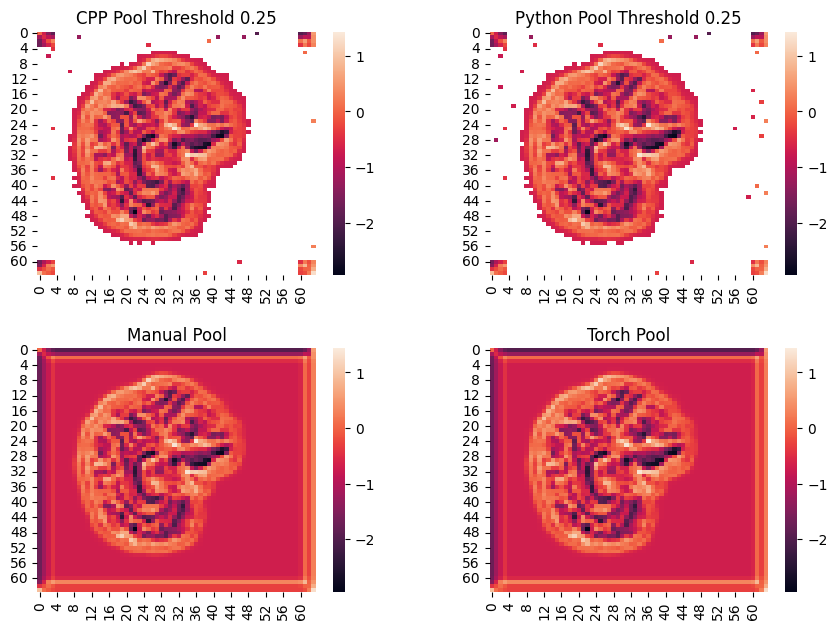

In [20]:
# Visualize output
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')
sns.heatmap(np.mean(nanoutputPy.detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')
sns.heatmap(np.mean(normaloutput.detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')
sns.heatmap(np.mean(torchoutput.detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Visualizing the difference between both

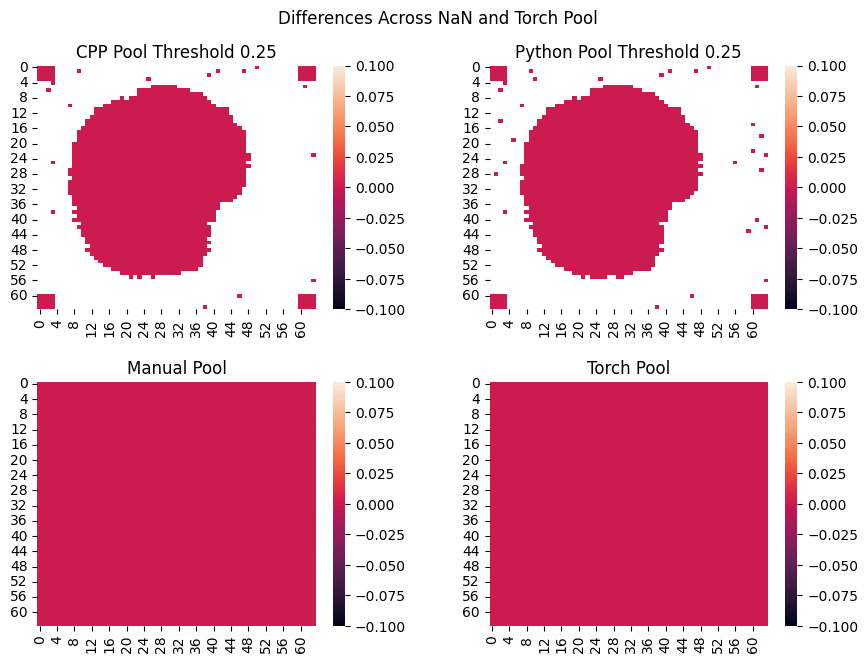

In [19]:
# %%timeit
# Visualize output differences -- should be 0
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Adjusted figure size for better layout

sns.heatmap(np.mean((nanoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')

sns.heatmap(np.mean((nanoutputPy - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')

sns.heatmap(np.mean((normaloutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')

sns.heatmap(np.mean((torchoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')

plt.suptitle('Differences Across NaN and Torch Pool')
# plt.savefig('/workspace/differences_comparison.png')  # Save the second plot
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

It can observed that the differences between both implementations (c++ and python) are very minimal. There are some small differences, mainly on the RHS of the image. However, C++ seems to ignore the background image a little better.



Exploring the time taken for each method

In [16]:
cpp_time = cppTime.average
py_time = pyTime.all_runs
normal_time = normalTime.all_runs
torch_time = torchTime.all_runs

cpp_time

97.62031910540027

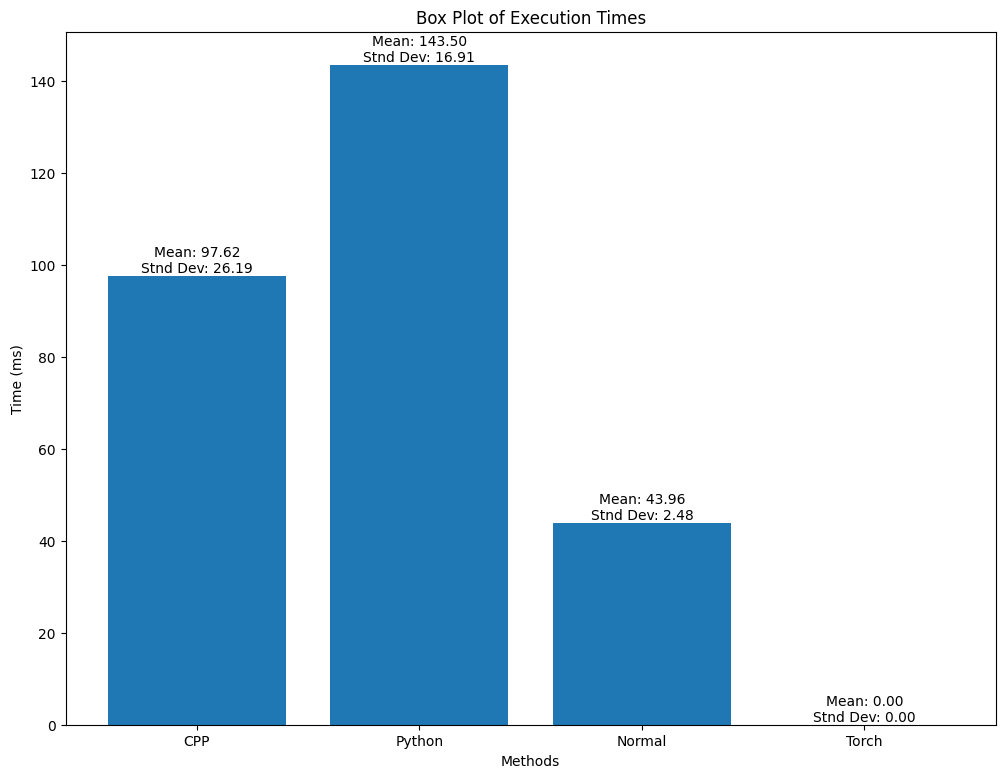

In [17]:
methods = ['CPP', 'Python', 'Normal', 'Torch']
times_objects = [cppTime, pyTime, normalTime, torchTime]

# Extracting the vectors from the time objects
cpp_time = cppTime.average
py_time = pyTime.average
normal_time = normalTime.average
torch_time = torchTime.average

# Extracting the standard deviations
cpp_std = cppTime.stdev
py_std = pyTime.stdev
normal_std = normalTime.stdev
torch_std = torchTime.stdev

times = [cpp_time, py_time, normal_time, torch_time]
times_stnd_dev = [cpp_std, py_std, normal_std, torch_std]

fig, ax = plt.subplots(figsize=(12, 9))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean, std_dev in zip(bars, times, times_stnd_dev):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}\nStnd Dev: {std_dev:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure

By observing the box plot, we notice a slight decrease in execution time between the Python and C++ implementations, as expected. Interestingly, the custom-written normal pooling method is faster than the NaN pooling method. This is expected because the computational speedup for NaN layers should be realized during the custom NaN convolution operation at the cost of a slower max pooling layer. NaNPooling involves additional comparisons to check for NaNs and duplicates, and to replace these values as necessary, which is not required in normal max pooling. However, during NaNConv, some convolutions should be skipped which should mean that we will see a faster execution time.

Given Torch's highly optimized code, matching its speed with our custom layers will be challenging. Notably, they can have different mathematical implementations (i.e., seperable filter, recursive convolution, using FFT [3]) or simply parallelizing the convolution operation [**source**]. However, if we can demonstrate that NaNPooling and NaNConv are faster than normal pooling and convolution, we can argue that NaN layers could outperform Torch's layers if subjected to the same level of optimization.

It can be observed that the improvement seen in our case reflect those found in pytorch's documentation found [here](https://pytorch.org/tutorials/advanced/cpp_extension.html). Their improvement takes about ~67% of the initial time whereas our takes about ~68% of our initial time. 

Documentation Example:
- Python custom implementation `Forward: 506.480 us | Backward 444.694 us`
- C++ custom implementation `Forward: 349.335 us | Backward 443.523 us`

NaN Pooling
- NaNPython custom implementation `NaNPooling: 143.50 sec`
- C++ custom implementation `NaNPooling: 97.62 sec`

# 5.0 Re-implementing in Torch Source

The observed disparity between the Torch source code and our custom implementation is too significant to overlook. Torch is exceptionally optimized, featuring custom MaxPooling functions tailored to the specific hardware executing the function, and is fine-tuned on a case-by-case basis. Consequently, recreating the custom implementations would be a monumental task. Instead of attempting to surpass its speed on our own, we will modify the specific function (e.g., by adding NaN checks, etc.), leveraging the existing work. This approach enables us to enhance and optimize our code without the need to start from scratch.

## 5.1 Source code installation
Similar to the Torch extension, a dockerfile and a .yml were used to ensure compatibility across OS's, reusability and to create contained envrionments. 

Conda .yml file
```yaml
name: torch_source
channels:
  - pytorch
  - defaults
dependencies:
  - python=3.10
  - cmake
  - clang
  - git
```
---

Dockerfile 
```Dockerfile
FROM ubuntu:20.04

# Set environment variables
ENV DEBIAN_FRONTEND=noninteractive
ENV LANG=C.UTF-8
ENV LC_ALL=C.UTF-8
ENV PATH /opt/conda/bin:$PATH

# Install required dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \
    wget \
    build-essential \
    ca-certificates \
    libjpeg-dev \
    libpng-dev \
    git \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*


RUN git clone --recursive https://github.com/pytorch/pytorch.git \
&& cd pytorch \
&& git checkout viable/strict \
&& git submodule sync \
&& git submodule update --init --recursive

# Install Anaconda
RUN wget --quiet https://repo.anaconda.com/archive/Anaconda3-2022.05-Linux-x86_64.sh -O /tmp/anaconda.sh && \
    /bin/bash /tmp/anaconda.sh -b -p /opt/conda && \
    rm /tmp/anaconda.sh
    
# Initialize Conda
COPY conda_env.yml conda_env.yml
RUN /opt/conda/bin/conda env create -f conda_env.yml
# Ensure the conda environment is activated for subsequent RUN commands
SHELL ["conda", "run", "-n", "torch_source", "/bin/bash", "-c"]

# Copy PyTorch requirements.txt and install PyTorch dependencies
RUN conda run -n torch_source pip install -r /pytorch/requirements.txt

RUN conda run -n torch_source conda install -y \
    intel::mkl-static \
    intel::mkl-include \
    && conda run -n torch_source conda clean -ya

# Fix ownership for git safety
RUN git config --global --add safe.directory '*'


ARG MAX_JOBS=$(nproc)
ARG USE_CUDA=0

# Additional instructions
RUN /bin/bash -c "source activate torch_source && \
                  cd /pytorch && \
                  export CMAKE_PREFIX_PATH=${CONDA_PREFIX:-"$(dirname $(which conda))/../"} && \
                  DEBUG=1 MAX_JOBS=${MAX_JOBS} USE_CUDA=${USE_CUDA} python setup.py develop --verbose"
```
---

This Dockerfile can be built and activated as follows:
1. Ensure you're in the folder containing Dockerfile and conda-env.yml 
2. ```docker build --no-cache --build-arg MAX_JOBS=16 -t <image-name> . ```
3. ```docker run --rm -it -v "$PWD:/workspace" <image_name>```

*** Note: this mounts your computer to /workspace in the docker container. In this case, it will create a new /workspace folder in the container. I recommend using ```mv``` to move the pytorch files into that workspace, so any changes made are saved after closing the environment. 

Once in the environment: 
1. Activate conda environment &rarr; ```source activate torch_source```
2. ```cd pytorch```

To test if everything is working, one can run any torch command in a python shell (launched from the /pytorch directory)

The build can be customized for difference scenarions (in the dockerfile + build commands, it was specified that cuda wasn't used and to use 16 cpus.). More settings exist on Torch documentation that can be inserted\modified into this build file. 

Some common mistakes that can happen: 
1. Process killed &rarr; ussually means running out of memory. Running *dmesg* can confirm this. &rarr; Can decrease MAX_JOBS
2. Might have a unstable version of github (make sure you're pulling from viable/strict if you're cloning yourself and not using the provided Dockerfile)
3. Other build flags that can be used (examples): DEBUG=1 USE_DISTRIBUTED=0 USE_MKLDNN=0 USE_CUDA=0 BUILD_TEST=0 USE_FBGEMM=0 USE_NNPACK=0 USE_QNNPACK=0 USE_XNNPACK=0




# 6. Torch Source Code Structure
TODO

## Works Cited:

[1] Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. J Big Data 8, 53 (2021). https://doi.org/10.1186/s40537-021-00444-8

[2] Zhao, L., Zhang, Z. A improved pooling method for convolutional neural networks. Sci Rep 14, 1589 (2024). https://doi.org/10.1038/s41598-024-51258-6

[3] **TODO** https://scicomp.stackexchange.com/questions/10356/computational-complexity-of-2d-convolution